In [2]:
import numpy as np
import supervision as sv
import cv2

# from ultralytics import YOLO

# model = YOLO('./src/yolov8s.pt')

VIDEO = "../data/vehicle-counting.mp4"
model_type = "large"
if model_type == "large":
    MODEL_PATH = "../models/yolov8l.pt"
else:   
    MODEL_PATH = "../src/yolov8s.pt"


colors = sv.ColorPalette.default()
video_info = sv.VideoInfo.from_video_path(VIDEO)
# video_info

# extract video frame
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)

True

We take the extracted first frame and plug it into PolygonZone to get the regions of interest as Numpy arrays: https://roboflow.github.io/polygonzone/

In [3]:
left_lane =np.array([
[1550, 426],[1546, 462],[1578, 494],[1498, 666],[1234, 970],[814, 1442],[170, 2142],[1750, 2146],[1670, 618],[1666, 390],[1598, 394],[1594, 434],[1550, 426]
])

    
right_lane = np.array([
[1710, 378],[1746, 558],[1810, 694],[2110, 1130],[2838, 2146],[3642, 2150],[3814, 2134],[3834, 1806],[3226, 1434],[2086, 750],[1942, 638],[1886, 582],[1826, 498],[1771, 394],[1708, 390]
])


polygons = [
    left_lane,
    right_lane
]

In [4]:
polygons[0].shape

(13, 2)

In [5]:
polygons[1].shape

(15, 2)

In [6]:
#initialize zones
zones = [
    sv.PolygonZone(
        polygon=polygon, 
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]

zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone, 
        color=colors.by_idx(index), 
        thickness=4,
        text_thickness=8, 
        text_scale=4,
    )
    for index, zone
    in enumerate(zones)
]

box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4, 
        text_scale=2, 
    ) 
    for index
    in range(len(polygons))
]

def process_frame(frame:np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
            
        labels = [
            f"{model.model.names[class_id]} {confidence:.02f}" 
            for _, _, confidence, class_id, _ 
            in detections_filtered
        ]
        frame = box_annotator.annotate(scene=frame, 
                                       detections=detections_filtered,
                                       labels=labels)
        frame = zone_annotator.annotate(scene=frame)
            
    return frame


In [11]:
from ultralytics import YOLO
model = YOLO(MODEL_PATH)

100%|██████████| 83.7M/83.7M [00:17<00:00, 4.92MB/s]


Manual inspection of the detection. If the inference found below looks good, continue running the remaining code. 

['truck 0.93', 'car 0.82', 'bicycle 0.39']
['car 0.89']


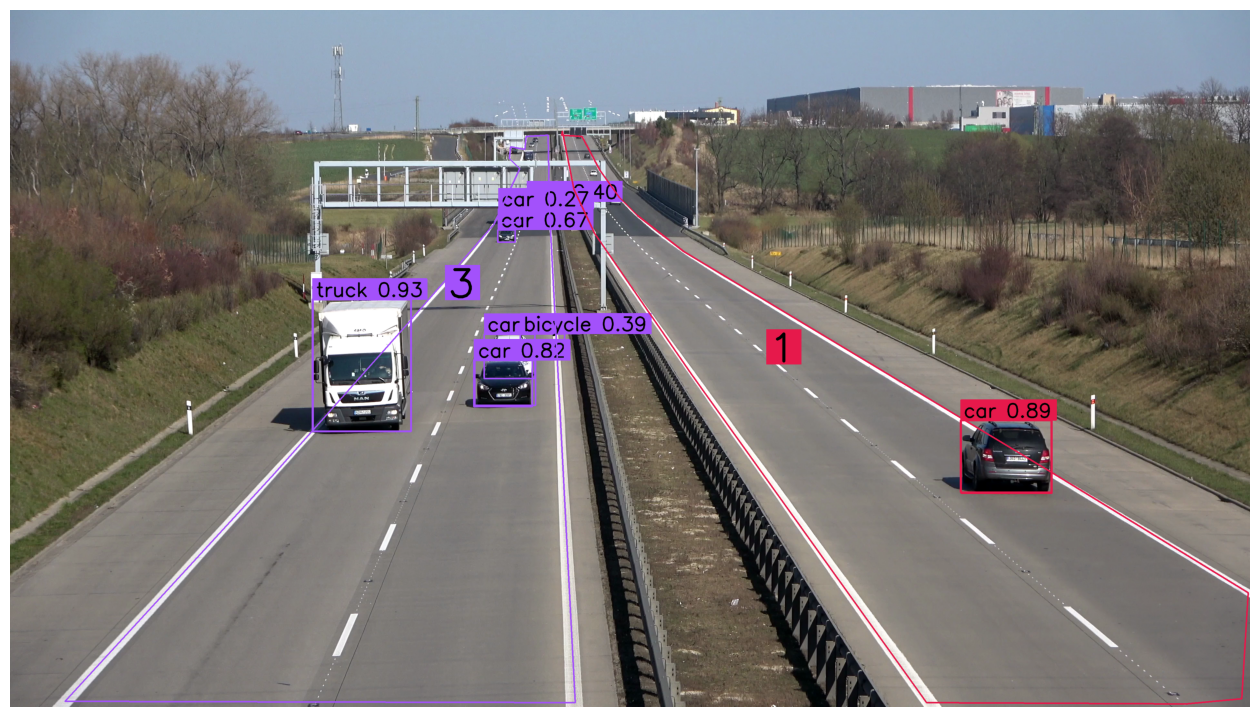

In [12]:
results = model(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    # add human-readable labels to detections
    detections_filtered = detections[mask]
    labels = [
        f"{model.model.names[class_id]} {confidence:.02f}" for _, _, confidence, class_id, _ in detections_filtered

    ]
    print(labels)
    frame = box_annotator.annotate(scene=frame, 
                                   detections=detections_filtered,
                                   labels=labels)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

In [13]:
sv.process_video(source_path=VIDEO, target_path=f"../data/result_yolov8_{model_type}.mp4", callback=process_frame)